### Imports

In [1]:
import scipy as sci
from scipy import stats
from scipy.special import expit
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
%matplotlib widget


### Read Data

In [2]:
file = 'examen.csv'
data = pd.read_csv(file, index_col=None, header=None).reset_index(drop=True)
N_S = len(data.index)
indices = data.index

### Preprocess

In [3]:
X_S = data.iloc[:, :3]

def normalize(points):
    min = points.min(axis=0)
    scale = points.max(axis=0) - min
    def denormalize(points):
        return points * scale + min
    return (points - min) / scale, denormalize

X_S, denormalize = normalize(X_S)
X_S, Y_S = X_S.iloc[:, :2], X_S.iloc[:, 2]

def label_to_int(data):
    labels = data.unique()
    label_map = dict(zip(labels, range(len(labels))))
    return data.apply(lambda x: label_map[x]), labels

#Y_S, labels = label_to_int(Y_S)
print(X_S)
print(Y_S)

                0         1
0    0.000000e+00  0.065486
1    0.000000e+00  0.067190
2    3.129944e-08  0.068910
3    9.469850e-08  0.070630
4    1.910228e-07  0.072365
..            ...       ...
896  9.979831e-01  0.003471
897  9.984771e-01  0.002603
898  9.990121e-01  0.001730
899  9.995061e-01  0.000862
900  1.000000e+00  0.000000

[901 rows x 2 columns]
0      0.000000e+00
1      0.000000e+00
2      1.946091e-15
3      0.000000e+00
4      0.000000e+00
           ...     
896    9.939907e-01
897    9.955076e-01
898    9.969662e-01
899    9.984831e-01
900    1.000000e+00
Name: 2, Length: 901, dtype: float64


### Learner measures

In [4]:
# lower bound to sample size
def PAC_eta(H_norm, delta, epsilon):
    return (np.ln(H_norm) - np.ln(delta))/epsilon

# lower bound to generalization error
def PAC_delta(H_norm, epsilon, eta):
    return H_norm/np.exp(eta*epsilon)


# Sampling

### Sampling Distributions

Text(0.5, 0, 'Sample Index')

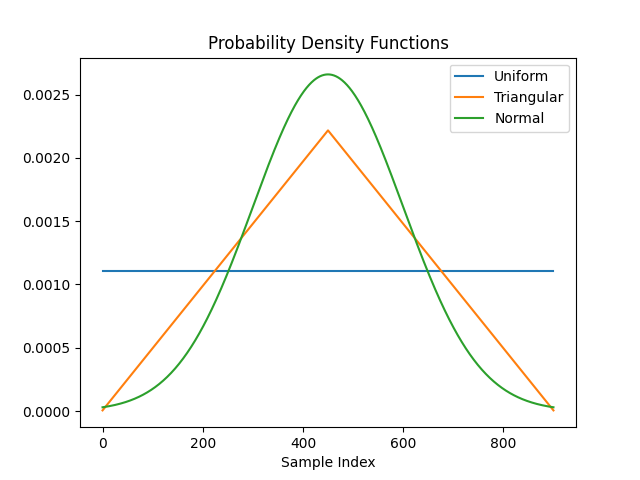

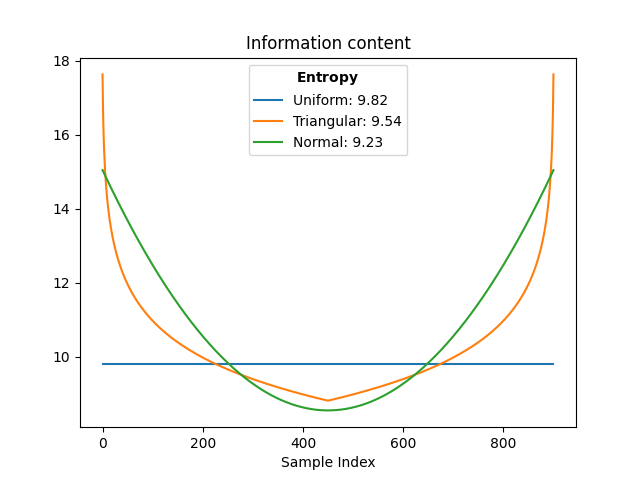

In [5]:
def pdf(pdf, x, N): return pd.Series({
    "Uniform": sci.stats.uniform.pdf(x, 0, N),
    "Triangular": sci.stats.triang.pdf(x, 0.5, -1, N+1),
    "Normal": sci.stats.norm.pdf(x, N//2, N//6)}[pdf], index=x)

plt.figure()
pdf_names = ["Uniform", "Triangular", "Normal"]
for name in pdf_names:
    F = pdf(name, indices, N_S)
    plt.plot(indices, F, label=name)
plt.legend()
plt.title("Probability Density Functions")
plt.xlabel("Sample Index")

plt.figure()
for name in pdf_names:
    F = pdf(name, indices, N_S)
    I = np.log2(1/F)
    H = np.sum(-F*np.log2(F))
    plt.plot(indices, I, label=f"{name}: {H:.2f}")
plt.legend(title="$\\bf{Entropy}$")
plt.title("Information content")
plt.xlabel("Sample Index")

### Comparison of samples

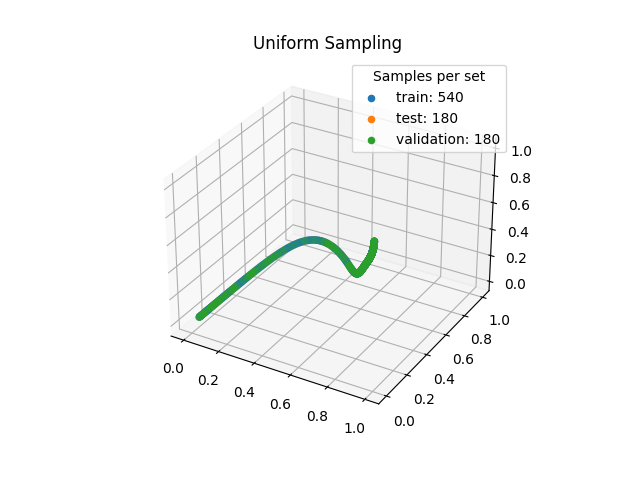

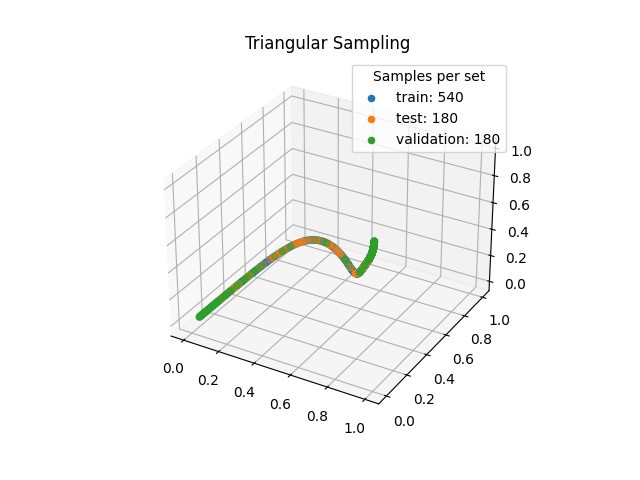

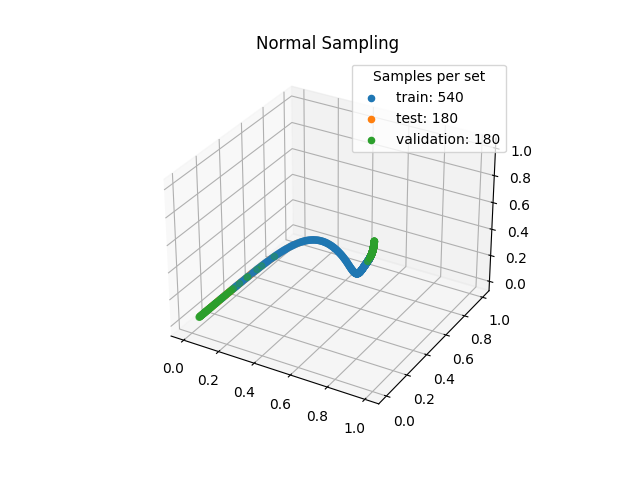

In [6]:
def set_axis_labels(ax, x, y, z):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

sets_uniform = {"train": int(0.6*N_S),
        "test": int(0.2*N_S),
        "validation": int(0.2*N_S)}

for name in pdf_names:
    weights = pdf(name, indices, N_S)
    sets = {"train": int(0.6*N_S),
            "test": int(0.2*N_S),
            "validation": int(0.2*N_S)}
    plt.figure()
    ax = plt.axes(projection='3d', title=f"{name} Sampling")
    for k, v in sets.items():
        Y_sample = Y_S[weights.index].sample(n=v, weights=weights)
        X_sample = X_S.iloc[Y_sample.index, :2]
        if name == "Uniform":
            sets_uniform[k] = (X_sample, Y_sample)
        weights = weights.drop(Y_sample.index)
        ax.scatter(X_sample.iloc[:, 0].values,
                   X_sample.iloc[:, 1].values,
                   Y_sample.values, label = f"{k}: {len(Y_sample.index)}")
    plt.legend(title="Samples per set")


# Training

In [ ]:
# gets B such that ||Y-XB||^2 is minimized
def linear_regression(X, Y):
    # Adds a 1s column to X to represent a constant parameter
    X = np.append(X, np.ones((X.shape[0], 1)), axis=1)
    Beta = np.asmatrix(X.T @ X).I @ X.T @ Y
    return Beta


weights = pdf("Uniform", indices, N_S)
sets = {"train": int(0.6*N_S), 
        "test": int(0.2*N_S),
        "validation": int(0.2*N_S)}

for k, v in sets.items():
    Y = Y_S[weights.index].sample(n=v, weights=weights)
    sets[k] = (X_S.iloc[Y.index, :], Y)
    weights = weights.drop(Y.index)

X, Y = sets["train"]

Beta = linear_regression(X, Y)

for k in sets:
    X, Y = sets[k]
    X = X.copy()
    X["ones"] = np.ones(X.shape[0])
    Z = np.round(X @ Beta)

    plt.figure()
    ax = plt.axes(projection='3d', title=f"Linear Regression {k}")
    TP_total = 0
    FP_total = 0

    error_str = lambda T, F: f"{F}/{F+T} ({F/(F+T):.2%})"
    for (k, v) in enumerate(labels):
        TP = (Z == k) & (Y == k)
        TP_sum = np.sum(TP)
        TP_total += TP_sum
        FP = (Z == k) & (Y != k)
        FP_sum = np.sum(FP)
        FP_total += FP_sum

        color = ax._get_lines.get_next_color()
        if TP_sum > 0:
            ax.scatter(*zip(*X[TP].iloc[:,0:3].values),
                    label=f"{v}: {error_str(TP_sum, FP_sum)}", color=color)
        if FP_sum > 0:
            ax.scatter(*zip(*X[FP].iloc[:, 0:3].values.tolist()), marker="x", color=color)
    plt.legend(title=f"Errors: {error_str(TP_total, FP_total)}")
    set_axis_labels(ax, *X.columns[0:3])

### Neural Network

In [7]:
def to_vector(Y, cats):
    id = np.identity(cats)
    return np.array([id[c, :] for c in Y])
    
def sequential(X, Yd, W, phi, dphi):
    p = X.shape[1]

    # feedforward
    V = [None] * (k+1)
    Y = [None] * (k+1)
    Y[0] = X
    for l in range(1, k+1):
        V[l] = W[l] @ Y[l-1]
        Y[l] = phi(V[l])
    softmax = lambda x: np.exp(x) / sum(np.exp(x))
    dsoftmax = lambda x: np.diag(softmax(x).flatten()) @ (np.eye(x.shape[0]) - softmax(x))
    #Y[k] = softmax(V[k])

    # backpropagation
    dE = Y[k] - Yd
    E = np.diag((Y[k] - Yd).T @ (Y[k] - Yd))/2

    delta = [None] * (k+1)
    delta[k] = dE * dphi(V[k])
    #delta[k] = np.column_stack([dsoftmax(V[k][:, [c]]) @ dE[:, [c]] for c in range(p)])
    for l in reversed(range(1, k)):
        delta[l] = (W[l+1].T @ delta[l+1]) * dphi(V[l])

    # update
    for l in range(1, k+1):
        W[l] -= (delta[l] @ Y[l-1].T) / p
    return W, delta, E


(180,)
(180,)
(180,)
(180,)
(180,)
(180,)
(180,)
(180,)
(180,)
(180,)
(180,)


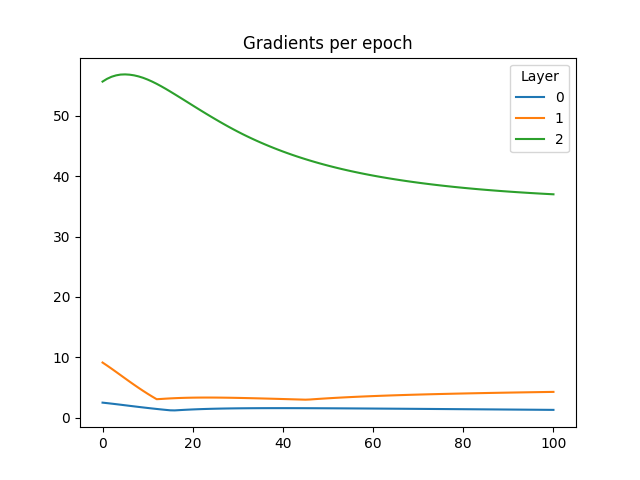

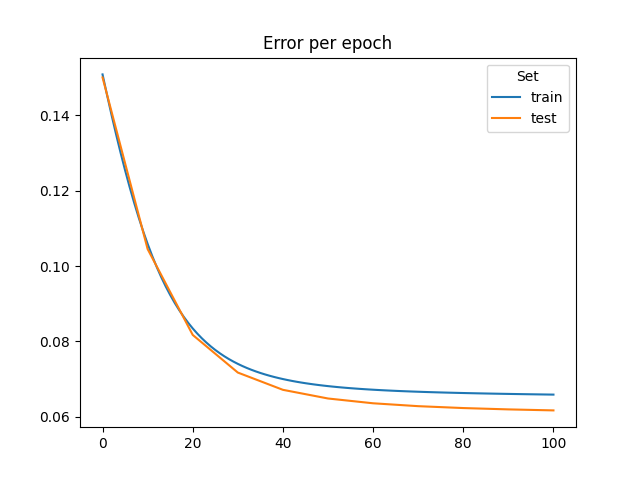

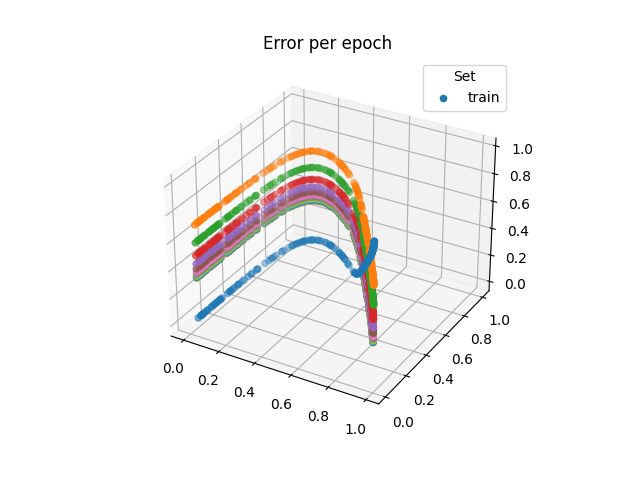

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 1.8000000715255737, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 1.8000000715255737, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 1.8000000715255737, 'type': 'set_device_pixel_ratio'}


In [8]:
X, Yd = sets_uniform["train"]
X, Yd = X.to_numpy().T, Yd.to_numpy()[:, None].T
X_test, Y_test = sets_uniform["test"]
X_test, Y_test = X_test.to_numpy().T, Y_test.to_numpy().T

neurons = [X.shape[0], 2, 2, Yd.shape[0]]
k = len(neurons) - 1

np.random.seed(69)
W = [None] * (k+1)
for l in range(1, k+1):
    W[l] = np.random.randn(neurons[l], neurons[l-1])

phi = expit
def dphi(x): return phi(x) * (1 - phi(x))
#phi = lambda x: x
#dphi = lambda x: np.ones(x.shape)

deltas = []
errors = {"train": [],
          "test": [],
          "validation": []}
ys = []
epochs = 101
for i in range(epochs):
    W, b, E = sequential(X, Yd, W, phi, dphi)
    deltas.append([np.mean(sum(np.abs(b[l].T))) for l in range(1, k+1)])
    errors["train"].append(sum(E)/X.shape[1])
    if i%10 == 0:
        Y_last = X_test
        for l in range(1, k+1):
            V_last = W[l] @ Y_last
            Y_last = phi(V_last)
        E = np.diag((Y_last - Y_test).T @ (Y_last - Y_test))/2
        errors["test"].append(sum(E)/Y_last.shape[1])
        ys.append([Y_last])

deltas = np.array(deltas).T

plt.figure()
ax = plt.axes(title=f"Gradients per epoch")
ax.plot(range(epochs), deltas.T)
ax.legend(range(deltas.shape[0]), title="Layer")

plt.figure()
ax = plt.axes(title=f"Error per epoch")
ax.plot(range(epochs), errors["train"], label="train")
ax.plot(range(0, epochs, 10), errors["test"], label="test")
plt.legend(title="Set")

plt.figure()
ax = plt.axes(projection="3d", title=f"Error per epoch")
ax.scatter(X_test[0, :], X_test[1, :], Y_test, label="train")
for k, y in enumerate(ys):
    print(Y_test.shape)
    ax.scatter(X_test[0, :], X_test[1, :], y[0])
plt.legend(title="Set")
